In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.metrics import log_loss, classification_report, precision_recall_curve
from sklearn.preprocessing import LabelBinarizer,StandardScaler
from sklearn import neural_network

from keras.layers import Dense
from keras.activations import sigmoid,relu
from keras.optimizers import RMSprop,Adam
from keras.losses import categorical_crossentropy, CategoricalCrossentropy
from keras import Sequential


Using TensorFlow backend.


In [2]:
CCE = CategoricalCrossentropy()

In [3]:
np.random.seed(1234)

In [4]:
iris_dataset = load_iris()
lb = LabelBinarizer()


X = iris_dataset.data
y = iris_dataset.target


# lb.fit(y)


data = np.concatenate((X[:100],y[:100].reshape(-1,1)), axis = 1)
np.random.shuffle(data)


X_train = data[:, :-1]

ss = StandardScaler()

X_train = ss.fit_transform(X_train)

y_train = data[: , -1].reshape(-1,1)

X_train.shape, y_train.shape

((100, 4), (100, 1))

In [5]:
def my_sigmoid(x):
    
    return ( (np.exp(x)) / (1 + np.exp(x) )  )


def Relu(x):
    return np.maximum(0,x)


def derivative_Relu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x


def relu_activation_derivative(dA, Z):
    
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    
    return dZ

def sigmoid_derivative(x):
    
    s = sigmoid(x).numpy()
    
    return s * (1-s)

def my_softmax(x, axis = 1):
        
    x -= np.max(x, axis=axis, keepdims=True)
    return np.exp(x) / np.exp(x).sum(axis=axis, keepdims=True)


def softmax_grad(softmax):
    # Reshape the 1-d softmax to 2-d so that np.dot will do the matrix multiplication
    s = softmax.reshape(-1,3)
    return np.diagflat(s) - np.dot(s, s.T)


In [6]:
def do(lr, epochs = 200, algo = "Momentum", nesterov = False, Use_new = False, dictionary = None):
    
    parameters = { }
    
    activations = { }
    
    Derivatives = { }
    
    Loss = []
    
    Beta = float(0.9)
    
    if algo == "Adam":
        
        Beta1 = np.float64(0.9); Beta2 = np.float64(0.999)
    
    if not Use_new:
        
        # X row vector (150 rows, 4 columns) => 4,150
        theta1 = np.random.randn(4, 3) *np.sqrt(2/4) # = 0.7
        theta2 = np.random.randn(3, 3) *np.sqrt(2/3) # = 0.81
        theta3 = np.random.randn(3, 1) *np.sqrt(1/6) # = 0.81
        
    elif Use_new:
        theta1 = dictionary["theta1"];
        theta2 = dictionary["theta2"];
        theta3 = dictionary["theta3"]
    

    for i in range(epochs):

        Z1 = X_train.dot(theta1)
        A1 = relu(Z1).numpy()

        Z2 = A1.dot(theta2)
        A2 = relu(Z2).numpy()

        Z3 = A2.dot(theta3)
        A3 = sigmoid(Z3).numpy()


        LL = log_loss(y_train,A3 )
        Loss.append(LL)
        if i% 20 == 0:

            print( "Epoch: {} , loss: {}".format(i,  LL) )

        # Backward
#         DL_A3 = np.divide(1-y_train, 1-A3) - \
#         np.divide(y_train, A3)

#         DA3_Z3 = sigmoid_derivative(Z3) # - y/a + (1-y/ 1-a) * s(x) * (1-s(x))

        m = X_train.shape[0]
        
#         DL_DW3 = ( DZ3_W3.dot( DL_A3 * DA3_Z3   )  ) / X_train.shape[0]
#         DL_DZ3 = DL_A3 * DA3_Z3


        DL_DZ3 = A3.reshape(-1,1) - y_train.reshape(-1,1)
        DZ3_W3 = A2.T
        DL_DW3 = (1./m)* ( DZ3_W3.dot( DL_DZ3   )  )
        


        DL_A2 = (DL_DZ3).dot(theta3.T)

#         DA2_Z2 = relu_activation_derivative(DL_A2, Z2)
        
        DA2_Z2 = derivative_Relu(Z2) # (A2>0)
        DZ2_W2 = A1.T

        DL_DW2 = (1./m) *(DZ2_W2.dot(DL_A2* DA2_Z2)  )
        DL_DZ2 = DL_A2 * DA2_Z2


        DL_A1 = DL_DZ2.dot(theta2.T)

#         DA1_Z1 = relu_activation_derivative(DL_A1, Z1)
        DA1_Z1 = derivative_Relu(Z1)
        DZ1_W1 = X_train.T

        DL_DW1 = (1./m) * DZ1_W1.dot( DL_A1 * DA1_Z1 )

        if algo == "Momentum" and Use_new == False:

            if i == 0:
                m1 = np.zeros(DL_DW1.shape); m2 = np.zeros(DL_DW2.shape); m3 = np.zeros(DL_DW3.shape)

            Bm1 = (Beta * m1); Bm2 = (Beta * m2); Bm3 = (Beta * m3)

            if nesterov:
                # Nesterov Momentum optimization 
                m1 = Bm1 - ( lr * ( DL_DW1 + Bm1 ) )
                m2 = Bm2 - ( lr * ( DL_DW2 + Bm2 ) )
                m3 = Bm3 - ( lr * ( DL_DW3 + Bm3 ) )

            else:

                # Momentum optimization
                m1 = Bm1 - ( lr * (DL_DW1) )
                m2 = Bm2 - ( lr * (DL_DW2) )
                m3 = Bm3 - ( lr * (DL_DW3) )

            theta1 += m1
            theta2 += m2
            theta3 += m3

        elif algo == "Adagrad" and Use_new == False:

            if i == 0:
                s1 = np.zeros(DL_DW1.shape); s2= np.zeros(DL_DW2.shape) ; s3 = np.zeros(DL_DW3.shape)

            
            s1 += np.power(DL_DW1, 2); s2+= np.power(DL_DW2, 2) ; s3 += np.power(DL_DW3, 2)
            
            theta1 = theta1 - ( (lr * DL_DW1) / np.sqrt(s1 + 10e-10) )  
            theta2 = theta2 - ( (lr * DL_DW2) / np.sqrt(s2 + 10e-10) )  
            theta3 = theta3 - ( (lr * DL_DW3) / np.sqrt(s3 + 10e-10) )
        
        elif algo == "RMSProp" and Use_new == False:
            
            if i == 0:
                s1 = np.zeros(DL_DW1.shape) ; s2 = np.zeros(DL_DW2.shape)
                s3 = np.zeros(DL_DW3.shape)
                
            
            s1 = (Beta * s1) + ( (1 - Beta) * np.power(DL_DW1, 2) )
            s2 = (Beta * s2) + ( (1 - Beta) * np.power(DL_DW2, 2) )
            s3 = (Beta * s3) + ( (1 - Beta) * np.power(DL_DW3, 2) )
            
            theta1 = theta1 - ( (lr * DL_DW1) / np.sqrt(s1 + 1e-10) )
            theta2 = theta2 - ( (lr * DL_DW2) / np.sqrt(s2 + 1e-10) )
            theta3 = theta3 - ( (lr * DL_DW3) / np.sqrt(s3 + 1e-10) )
            
        elif algo == "Adam":
            
            if i == 0 and Use_new == False:
                m1 = np.zeros(DL_DW1.shape, dtype = np.float64)
                m2 = np.zeros(DL_DW2.shape,dtype = np.float64)
                m3 = np.zeros(DL_DW3.shape, dtype = np.float64)
                
                s1 = np.zeros(DL_DW1.shape,dtype = np.float64)
                s2 = np.zeros(DL_DW2.shape, dtype = np.float64)
                s3 = np.zeros(DL_DW3.shape, dtype = np.float64)
            
            
            
            m1 = (Beta1 * m1) + ( (1. - Beta1) * DL_DW1 )
            m2 = (Beta1 * m2) + ( (1. - Beta1) * DL_DW2 )
            m3 = (Beta1 * m3) + ( (1. - Beta1) * DL_DW3 )
            
            s1 = (Beta2 * s1) + ( (1. - Beta2) * np.square(DL_DW1) )
            s2 = (Beta2 * s2) + ( (1. - Beta2) * np.square(DL_DW2)  )
            s3 = (Beta2 * s3) + ( (1. - Beta2) * np.square(DL_DW3)  )
            
            
            m1c = m1 / (1. - ( Beta1 ** (i+1) )  )
            m2c = m2 / (1. - ( Beta1 ** (i+1))  )
            m3c = m3 / (1. - ( Beta1 ** (i+1))  )
            
            s1c = s1 / (1. - ( Beta2** (i+1)  )  )
            s2c = s2 / (1. - ( Beta2 ** (i+1))  )
            s3c = s3 / (1. - ( Beta2 ** (i+1))  )
            
            
            tss1 = lr * m1c / ( np.sqrt(s1c) + 1e-8)
            tss2 = lr * m2c / ( np.sqrt(s2c) + 1e-8)
            tss3 = lr * m3c / ( np.sqrt(s3c) + 1e-8)
            
            
            theta1 = theta1 - tss1
            theta2 = theta2 - tss2
            theta3 = theta3 - tss3
            
        else:
            pass
            
#             theta1 = theta1 - ( lr * DL_DW1 )
#             theta2 = theta2 - ( lr * DL_DW2 )
#             theta3 = theta3 - ( lr * DL_DW3 )

    
    parameters["theta1"] = theta1; parameters["theta2"] = theta2; parameters["theta3"] = theta3
    
    activations["A1"] = A1; activations["A2"] = A2; activations["A3"] = A3
    
    Derivatives["DW1"] = DL_DW1; Derivatives["DW2"] = DL_DW2; Derivatives["DW3"] = DL_DW3
    
    return (parameters, activations, Derivatives, Loss)
            
    

    
    
    
parameters, activations, Derivatives, Loss = do(lr = 1e-2 , epochs = 1, algo = "GD", nesterov = True)

# lr 1e-2, epochs = 500, RMSProp : Epoch: 480 , loss: 0.3465736144979975
# lr 1e-2, epochs = 500, Momentum, No Nesterov: Epoch: 480 , loss: 0.6925557243217672
# lr 1e-2, epochs = 500, Momentum, With Nesterov: Epoch: 480 , loss: 0.6927930940792854



# lr 1e-1, epochs = 500, RMSProp : Epoch: 480 , loss: 0.6931471805599453
# lr 1e-1, epochs = 500, Momentum, No Nesterov:  Epoch: 480 , loss: 0.34657382330524106
# lr 1e-1, epochs = 500, Momentum, With Nesterov: Epoch: 480 , loss: 0.3466761685732003

Epoch: 0 , loss: 0.6938988100096825


In [7]:
ti = 97

In [8]:
# my_sigmoid( (X_train[ti, : ].reshape(-1,4).dot(theta1)).dot(theta2).dot(theta3) )

In [9]:
y_train[ti]

array([0.])

In [10]:
Keras_model  = Sequential()

Keras_model.add( Dense(3, activation='relu', use_bias = False, input_shape = (4, ))  )

Keras_model.add( Dense (3, activation= 'relu', use_bias=False, input_shape = (3, )))

Keras_model.add( Dense (1, activation= 'sigmoid', use_bias=False, input_shape = (3, )))

Adam_optim = Adam(learning_rate=1e-2)

Keras_model.compile(loss='binary_crossentropy', optimizer=Adam_optim, metrics = ['accuracy'])

In [11]:
Keras_model.fit(X_train, y_train, epochs=700, batch_size=100)

Epoch 1/700
100/100 [==============================] - 0s 708us/step - loss: 0.5686 - accuracy: 0.7300
Epoch 2/700
100/100 [==============================] - 0s 10us/step - loss: 0.5551 - accuracy: 0.7700
Epoch 3/700
100/100 [==============================] - 0s 20us/step - loss: 0.5439 - accuracy: 0.7800
Epoch 4/700
100/100 [==============================] - 0s 10us/step - loss: 0.5316 - accuracy: 0.7800
Epoch 5/700
100/100 [==============================] - 0s 10us/step - loss: 0.5183 - accuracy: 0.8100
Epoch 6/700
100/100 [==============================] - 0s 10us/step - loss: 0.5063 - accuracy: 0.8200
Epoch 7/700
100/100 [==============================] - 0s 10us/step - loss: 0.4944 - accuracy: 0.8300
Epoch 8/700
100/100 [==============================] - 0s 10us/step - loss: 0.4829 - accuracy: 0.8400
Epoch 9/700
100/100 [==============================] - 0s 10us/step - loss: 0.4718 - accuracy: 0.8500
Epoch 10/700
100/100 [==============================] - 0s 10us/step - loss: 0.46

Epoch 81/700
100/100 [==============================] - 0s 10us/step - loss: 0.3482 - accuracy: 0.9900
Epoch 82/700
100/100 [==============================] - 0s 10us/step - loss: 0.3481 - accuracy: 0.9900
Epoch 83/700
100/100 [==============================] - 0s 0us/step - loss: 0.3481 - accuracy: 0.9900
Epoch 84/700
100/100 [==============================] - 0s 0us/step - loss: 0.3481 - accuracy: 0.9900
Epoch 85/700
100/100 [==============================] - 0s 0us/step - loss: 0.3481 - accuracy: 0.9900
Epoch 86/700
100/100 [==============================] - 0s 10us/step - loss: 0.3480 - accuracy: 0.9900
Epoch 87/700
100/100 [==============================] - 0s 10us/step - loss: 0.3480 - accuracy: 0.9900
Epoch 88/700
100/100 [==============================] - 0s 10us/step - loss: 0.3480 - accuracy: 0.9900
Epoch 89/700
100/100 [==============================] - 0s 0us/step - loss: 0.3479 - accuracy: 0.9900
Epoch 90/700
100/100 [==============================] - 0s 10us/step - loss: 

Epoch 161/700
100/100 [==============================] - 0s 10us/step - loss: 0.3470 - accuracy: 1.0000
Epoch 162/700
100/100 [==============================] - 0s 10us/step - loss: 0.3470 - accuracy: 1.0000
Epoch 163/700
100/100 [==============================] - 0s 10us/step - loss: 0.3470 - accuracy: 1.0000
Epoch 164/700
100/100 [==============================] - 0s 10us/step - loss: 0.3470 - accuracy: 1.0000
Epoch 165/700
100/100 [==============================] - 0s 10us/step - loss: 0.3470 - accuracy: 1.0000
Epoch 166/700
100/100 [==============================] - 0s 20us/step - loss: 0.3470 - accuracy: 1.0000
Epoch 167/700
100/100 [==============================] - 0s 10us/step - loss: 0.3470 - accuracy: 1.0000
Epoch 168/700
100/100 [==============================] - 0s 10us/step - loss: 0.3470 - accuracy: 1.0000
Epoch 169/700
100/100 [==============================] - 0s 10us/step - loss: 0.3470 - accuracy: 1.0000
Epoch 170/700
100/100 [==============================] - 0s 10us

Epoch 240/700
100/100 [==============================] - 0s 10us/step - loss: 0.3468 - accuracy: 1.0000
Epoch 241/700
100/100 [==============================] - 0s 10us/step - loss: 0.3468 - accuracy: 1.0000
Epoch 242/700
100/100 [==============================] - 0s 10us/step - loss: 0.3468 - accuracy: 1.0000
Epoch 243/700
100/100 [==============================] - 0s 10us/step - loss: 0.3468 - accuracy: 1.0000
Epoch 244/700
100/100 [==============================] - 0s 10us/step - loss: 0.3468 - accuracy: 1.0000
Epoch 245/700
100/100 [==============================] - 0s 10us/step - loss: 0.3468 - accuracy: 1.0000
Epoch 246/700
100/100 [==============================] - 0s 0us/step - loss: 0.3468 - accuracy: 1.0000
Epoch 247/700
100/100 [==============================] - 0s 10us/step - loss: 0.3468 - accuracy: 1.0000
Epoch 248/700
100/100 [==============================] - 0s 10us/step - loss: 0.3468 - accuracy: 1.0000
Epoch 249/700
100/100 [==============================] - 0s 0us/s

Epoch 319/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 320/700
100/100 [==============================] - 0s 0us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 321/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 322/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 323/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 324/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 325/700
100/100 [==============================] - 0s 0us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 326/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 327/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 328/700
100/100 [==============================] - 0s 10us/s

Epoch 398/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 399/700
100/100 [==============================] - 0s 0us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 400/700
100/100 [==============================] - 0s 0us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 401/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 402/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 403/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 404/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 405/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 406/700
100/100 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 1.0000
Epoch 407/700
100/100 [==============================] - 0s 10us/s

Epoch 477/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 478/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 479/700
100/100 [==============================] - 0s 0us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 480/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 481/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 482/700
100/100 [==============================] - 0s 0us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 483/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 484/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 485/700
100/100 [==============================] - 0s 0us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 486/700
100/100 [==============================] - 0s 10us/st

Epoch 556/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 557/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 558/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 559/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 560/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 561/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 562/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 563/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 564/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 565/700
100/100 [==============================] - 0s 10us

Epoch 635/700
100/100 [==============================] - 0s 0us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 636/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 637/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 638/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 639/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 640/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 641/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 642/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 643/700
100/100 [==============================] - 0s 10us/step - loss: 0.3466 - accuracy: 1.0000
Epoch 644/700
100/100 [==============================] - 0s 10us/

In [12]:
Keras_model.predict_proba(X_train[ti, : ].reshape(-1,4))

array([[0.5]], dtype=float32)

In [13]:
nn = neural_network.MLPClassifier(hidden_layer_sizes=(3,), activation = "relu",
                                 solver = 'sgd',
                                 learning_rate_init = 1e-1,
                                 max_iter = 200,
                                 shuffle = False)

nn.fit(X_train, y_train)

D:\Amith_Learning\Anaconda3\envs\Amith_Learning\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MLPClassifier(hidden_layer_sizes=(3,), learning_rate_init=0.1, shuffle=False,
              solver='sgd')

In [14]:
nn.n_layers_, nn.n_outputs_

(3, 1)

In [15]:
nn.loss_

0.0024201907071314103

In [16]:
nn.predict_proba(X_train[ti, : ].reshape(1,-1)), nn.predict(X_train[ti, : ].reshape(1,-1))

(array([[0.99830525, 0.00169475]]), array([0.]))

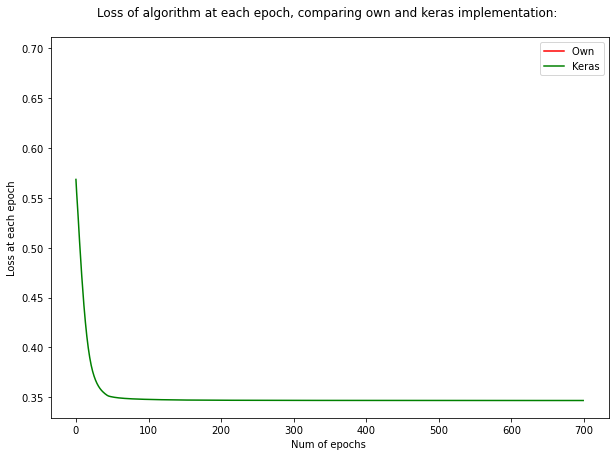

In [17]:

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(Loss, color = 'r')
plt.plot(Keras_model.history.history["loss"], color = 'g')
plt.legend(["Own ", "Keras"])
plt.title("Loss of algorithm at each epoch, comparing own and keras implementation: \n")
plt.xlabel("Num of epochs ")
plt.ylabel("Loss at each epoch")

plt.show()



In [18]:
def dictionary_to_vector(parameters):
    """
    Roll all our parameters dictionary into a single vector satisfying our specific required shape.
    """
    keys = []
    count = 0
    for key in ["theta1", "theta2", "theta3"]:
        
        # flatten parameter
        new_vector = np.reshape(parameters[key], (-1,1))
        keys = keys + [key]*new_vector.shape[0]
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta, keys

def vector_to_dictionary(theta):
    """
    Unroll all our parameters dictionary from a single vector satisfying our specific required shape.
    """
    parameters = {}
    parameters["theta1"] = theta[:12].reshape((4,3))
#     parameters["b1"] = theta[20:25].reshape((5,1))
    parameters["theta2"] = theta[12:21].reshape((3,3))
#     parameters["b2"] = theta[40:43].reshape((3,1))
    parameters["theta3"] = theta[21:].reshape((3,1))
#     parameters["b3"] = theta[46:47].reshape((1,1))

    return parameters

def gradients_to_vector(gradients):
    """
    Roll all our gradients dictionary into a single vector satisfying our specific required shape.
    """
    
    count = 0
    for key in ["DW1", "DW2", "DW3"]:
        # flatten parameter
        new_vector = np.reshape(gradients[key], (-1,1))
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta

In [19]:
parameters

{'theta1': array([[ 0.21167032,  0.0899986 ,  0.65491521],
        [ 1.73611677, -0.22690361, -0.22035332],
        [ 0.09260403,  0.18581741,  0.72391082],
        [-0.04426139, -0.83601255, -0.24377559]]),
 'theta2': array([[-0.20044229, -0.83772159,  0.04443767],
        [-0.33219047, -0.58186041,  0.70410224],
        [-0.47156783, -0.41789769,  0.3474615 ]]),
 'theta3': array([[-0.0260292 ],
        [ 0.08038196],
        [-0.04618847]])}

In [20]:
Derivatives

{'DW1': array([[ 0.00037581,  0.00583802,  0.00308186],
        [-0.00037064, -0.00624158, -0.00257465],
        [ 0.00049052,  0.00791522,  0.00390025],
        [ 0.00048873,  0.00784107,  0.00381596]]),
 'DW2': array([[ 0.        ,  0.        , -0.01215476],
        [ 0.        ,  0.        , -0.00446355],
        [ 0.        ,  0.        ,  0.01289029]]),
 'DW3': array([[ 0.        ],
        [ 0.        ],
        [-0.01723276]])}

In [21]:
parameter_values,_ = dictionary_to_vector(parameters)
grad = gradients_to_vector(Derivatives)
numparams = parameter_values.shape[0]
J_plus = np.zeros((numparams, 1))
J_minus = np.zeros((numparams, 1))
gradapprox = np.zeros((numparams, 1))
ep = 1e-7

In [22]:
numparams

24

In [23]:
for i in range(numparams):
    
    thetaplus = np.copy(parameter_values)
    thetaplus[i][0] = thetaplus[i][0] + ep
    
    _, _, _, J_plus[i] = do(lr = 1e-2 , epochs = 1, algo = "GD", nesterov = True, Use_new=True,
                           dictionary = vector_to_dictionary(thetaplus))
    
#     J_plus[i], _ =  forward_propagation_n(X, Y, vector_to_dictionary(thetaplus))  # Step 3
    
    
    thetaminus = np.copy(parameter_values)                                       # Step 1
    thetaminus[i][0] = thetaminus[i][0] - ep                                # Step 2        
    
    _, _, _, J_minus[i] = do(lr = 1e-2 , epochs = 1, algo = "GD", nesterov = True, Use_new=True,
                           dictionary = vector_to_dictionary(thetaminus))
    
#     J_minus[i], _ = forward_propagation_n(X, Y, vector_to_dictionary(thetaminus)) # Step 3
    ### END CODE HERE ###

    # Compute gradapprox[i]
    ### START CODE HERE ### (approx. 1 line)
    gradapprox[i] = ( (J_plus[i] - J_minus[i]) / (2 * ep) )

Epoch: 0 , loss: 0.6938988100472632
Epoch: 0 , loss: 0.6938988099721018
Epoch: 0 , loss: 0.6938988105934847
Epoch: 0 , loss: 0.6938988094258803
Epoch: 0 , loss: 0.6938988103178682
Epoch: 0 , loss: 0.6938988097014966
Epoch: 0 , loss: 0.6938988099726187
Epoch: 0 , loss: 0.693898810046746
Epoch: 0 , loss: 0.693898809385525
Epoch: 0 , loss: 0.6938988106338403
Epoch: 0 , loss: 0.6938988097522177
Epoch: 0 , loss: 0.6938988102671473
Epoch: 0 , loss: 0.6938988100587347
Epoch: 0 , loss: 0.6938988099606305
Epoch: 0 , loss: 0.6938988108012042
Epoch: 0 , loss: 0.6938988092181608
Epoch: 0 , loss: 0.693898810399707
Epoch: 0 , loss: 0.6938988096196579
Epoch: 0 , loss: 0.6938988100585557
Epoch: 0 , loss: 0.6938988099608092
Epoch: 0 , loss: 0.6938988107937892
Epoch: 0 , loss: 0.6938988092255758
Epoch: 0 , loss: 0.6938988103912781
Epoch: 0 , loss: 0.6938988096280869
Epoch: 0 , loss: 0.6938988100096825
Epoch: 0 , loss: 0.6938988100096825
Epoch: 0 , loss: 0.6938988100096825
Epoch: 0 , loss: 0.693898810009

In [24]:
numerator = np.linalg.norm((grad - gradapprox) )                                    # Step 1'
denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)                   # Step 2'
difference = numerator / denominator                                              # Step 3'
difference

3.508205033454513e-08

In [25]:
difference > 1e-7

False